# Clustering by RNA: Integration

*See the original hypothesis in `notebooks/cluster-rna.ipynb`*

Integrating data from [Poscablo 2024](https://doi.org/10.1016/j.cell.2024.04.018) and an [internal perinatal nicotine exposure dataset (dubbed PNE)](https://cells.ucsc.edu/?ds=mouse-pne-project+bonemarrow) may provide more insight. 

**Hypothesis**: When comparing young and old HSCs, old HSCs form distinct subclusters that may inform whether said old HSC would differentiate down the known hematopoiesis tree or to become a non-canonical MKP.

In [1]:
# setup: imports

import scanpy as sc
import harmonypy

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import pyrootutils

from pathlib import Path

from matplotlib.figure import Figure
from matplotlib.axes import Axes
from pandas import DataFrame
from scanpy import AnnData
from typing import Any

from scripts.plotting import plot_dual_celltypes

# setup: path constants

ROOT = pyrootutils.setup_root(Path.cwd(), indicator='.git')
DATA = ROOT / "data"
FIGURES = ROOT / "figures/cluster-rna-integrated"

POSCABLO_PATH = DATA / "rna_annotation_normalized.h5ad"
PNE_PATH = DATA / "pne-bonemarrow.h5ad"

# setup: verify paths

for path in POSCABLO_PATH, PNE_PATH:
    if not path.exists():
        raise FileNotFoundError(f"Could not find required input: {str(path)}")

FIGURES.mkdir(parents=True, exist_ok=True)

Let's render our two to-be-integrated anndata objects and view their current UMAP embeddings to get a sense of what our data looks like. These datasets share label:color maps, so after guaranteeing that property we can visualize them with a shared legend.

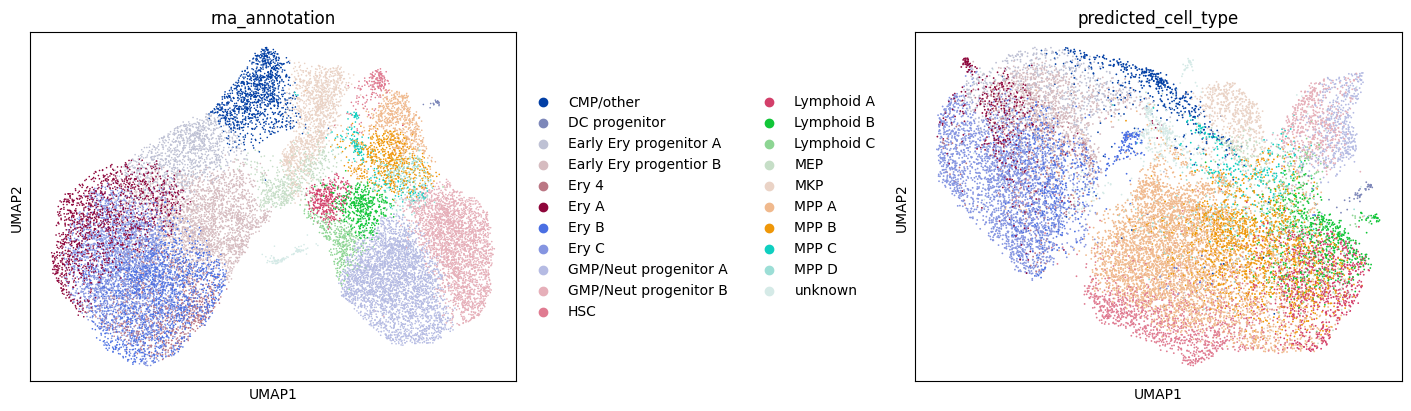

In [ ]:
poscablo = sc.read_h5ad(filename=POSCABLO_PATH)
pne = sc.read_h5ad(filename=PNE_PATH)


plot_shared_celltypes(
    adata1=poscablo, color_col1='rna_annotation',
    adata2=pne, color_col2='predicted_cell_type'
)

plot_dual_celltypes(
    
)

A little sanity check on the individual samples sequenced for the PNE dataset reveals that there is virtually no intra-dataset batch effects that may impact this analysis.

In [3]:
def plot_batches(adata: AnnData, batch_col: str, suptitle: str = "Treatment") -> None:
    batches = adata.obs[batch_col].unique()
    fig, axs = plt.subplots(
        nrows=1, 
        ncols=len(batches), 
        figsize=(5 * len(batches), 5), 
        constrained_layout=True
    )
    fig.suptitle(suptitle, size='xx-large')
    for ax, batch in zip(axs, batches):
        sc.pl.umap(
            adata=adata[adata.obs[batch_col] == batch], 
            ax=ax, 
            show=False, 
            title=f"Batch: {batch}", 
            legend_loc='best',
        )

# # uncomment function call to see by-treatment UMAP, but they're basically the same
# plot_batches(adata=pne, batch_col='Treatment', suptitle="Batch Effects for PNE Bone Marrow Dataset")

### Preparing for integration

**Joint Genes**
- self explanatory

**Filtering for CONTROL Mice**
- Nicotine exposure would be a confounding variable in this analysis, as we are only concerned with age. Only control mice will be selected for integration with Poscablo.

**Adding features**
- All PNE mice are young, so an Age column did not exist. Adding that and a batch label allows integration methods to differ between datasets.

**UMAP re-calculation**
- Just to get a sense of what the data looks like, the control-only UMAP is re-calculated and re-plotted

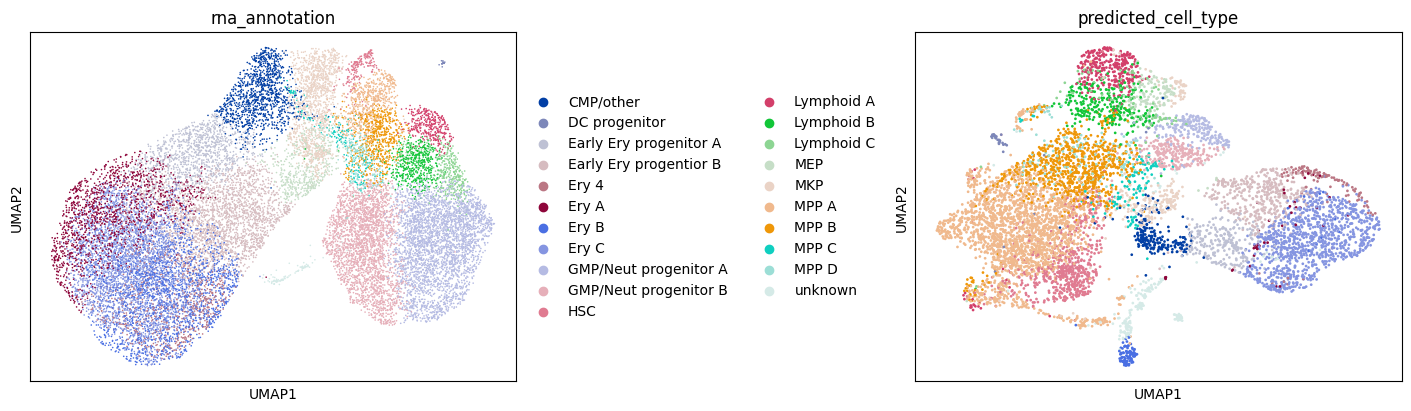

In [4]:
# select common genes
var_names = poscablo.var_names.intersection(pne.var_names)
poscablo = poscablo[:, var_names].copy()
pne = pne[:, var_names].copy()

# filter pne dataset for control mice
pne_ctrl = pne[pne.obs['Treatment'] == 'CONTROL'].copy()

# add age, batch, and cell type label features to datasets
poscablo_annot, pne_annot = 'rna_annotation', 'predicted_cell_type'
annot = 'cell_type_label'

pne_ctrl.obs['Age'] = pd.Categorical(['Young'] * len(pne_ctrl), categories=poscablo.obs['Age'].cat.categories)
pne_ctrl.obs['batch'] = 'pne'
pne_ctrl.obs[annot] = pne_ctrl.obs[pne_annot]
poscablo.obs['batch'] = 'poscablo'
poscablo.obs[annot] = poscablo.obs[poscablo_annot]


# recompute control-only umaps
for adata in poscablo, pne_ctrl:
    sc.pp.pca(data=adata)
    sc.pp.neighbors(adata=adata)
    sc.tl.umap(adata=adata)

# plot control-only umaps
plot_shared_celltypes(
    adata1=poscablo, color_col1='rna_annotation',
    adata2=pne_ctrl, color_col2='predicted_cell_type'
)

In [5]:
annot = 'cell_type_label'
pne_ctrl.obs[annot] = pne_ctrl.obs['predicted_cell_type']
poscablo.obs[annot] = poscablo.obs['rna_annotation']

### Integration methods

methods
- sc.tl.ingest
    - KNN-based approach
- sc.external.pp.harmony_integrate
    - python implementation of harmony
- scvi.model.SCVI
    - learned joint representation via variational autoencoder

AnnData object with n_obs × n_vars = 7802 × 20383
    obs: 'Sample', 'n_genes_by_counts', 'total_counts', 'total_counts_mt', 'pct_counts_mt', 'n_genes', 'doublet_score', 'predicted_doublet', 'EGFP', 'TDTOM', 'Egfp_expression', 'S_score', 'G2M_score', 'phase', 'predicted_cell_type', 'Fraction', 'Treatment', 'Age', 'batch', 'cell_type_label'
    var: 'gene_ids', 'feature_types', 'mt', 'ribo', 'n_cells_by_counts', 'mean_counts', 'pct_dropout_by_counts', 'total_counts', 'n_cells'
    uns: 'Egfp_expression_colors', 'Sample_colors', 'cell_type_colors', 'cell_type_gfp_colors', 'leiden_res_0.02', 'leiden_res_0.02_colors', 'leiden_res_0.50', 'leiden_res_0.50_colors', 'leiden_res_1.00', 'leiden_res_1.00_colors', 'leiden_res_2.00', 'leiden_res_2.00_colors', 'log1p', 'neighbors', 'pca', 'predicted_cell_type_colors', 'predicted_doublet_colors', 'rank_genes_groups', 'scrublet', 'umap'
    obsm: 'X_pca', 'X_umap', 'rep'
    varm: 'PCs'
    layers: 'counts'
    obsp: 'connectivities', 'distances'

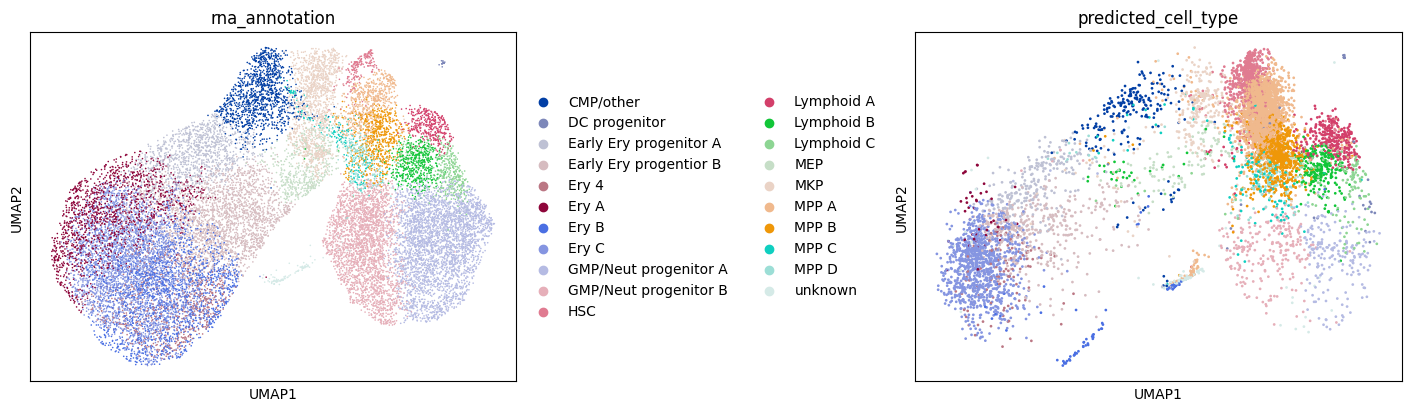

In [6]:
ingested_pne_ctrl = sc.tl.ingest(
    adata=pne_ctrl,
    adata_ref=poscablo,
    inplace=False
)

plot_shared_celltypes(adata1=poscablo, color_col1=poscablo_annot, adata2=ingested_pne_ctrl, color_col2=pne_annot)
ingested_pne_ctrl

In [ ]:
joint_adata = sc.concat(adatas=[poscablo, pne_ctrl])
assert len(joint_adata) == len(poscablo) + len(pne_ctrl)  # no shared cell labels were used

joint_adata

AnnData object with n_obs × n_vars = 30404 × 20383
    obs: 'Age', 'n_genes_by_counts', 'total_counts', 'total_counts_mt', 'pct_counts_mt', 'n_genes', 'doublet_score', 'Egfp_expression', 'batch', 'cell_type_label'
    uns: 'pca', 'neighbors', 'umap'
    obsm: 'X_pca', 'X_umap'
    varm: 'PCs'
    obsp: 'distances', 'connectivities'

In [19]:
joint_adata.obsm

AxisArrays with keys: X_pca, X_umap, X_pca_harmony

In [ ]:
pca_harmony_key = "X_pca_harmony"
neighbors_harmony_key = "neighbors_harmony"
umap_harmony_key = "X_umap_harmony"

def harmony_integrate(
        adata: sc.AnnData,
        key: str,
        *,
        basis: str = 'X_pca',
        adjusted_basis: str = 'X_pca_harmony',
        **kwargs
    ):
    """
    A hotfix for scanpy.external.pp.harmony_integrate() with near identical
    implementation. scanpy's harmony_integrate() implementation transposes
    the adata object for compatibility with older harmony versions, but this
    breaks with harmonypy>=0.1.0. 
    
    Issue + fix is documented here: https://github.com/scverse/scanpy/issues/3940

    Use harmonypy :cite:p:`Korsunsky2019` to integrate different experiments.

    Harmony :cite:p:`Korsunsky2019` is an algorithm for integrating single-cell
    data from multiple experiments. This function uses the python
    port of Harmony, ``harmonypy``, to integrate single-cell data
    stored in an AnnData object. As Harmony works by adjusting the
    principal components, this function should be run after performing
    PCA but before computing the neighbor graph, as illustrated in the
    example below.

    Parameters
    ----------
    adata
        The annotated data matrix.
    key
        The name of the column in ``adata.obs`` that differentiates
        among experiments/batches. To integrate over two or more covariates,
        you can pass multiple column names as a list. See ``vars_use``
        parameter of the ``harmonypy`` package for more details.
    basis
        The name of the field in ``adata.obsm`` where the PCA table is
        stored. Defaults to ``'X_pca'``, which is the default for
        ``sc.pp.pca()``.
    adjusted_basis
        The name of the field in ``adata.obsm`` where the adjusted PCA
        table will be stored after running this function. Defaults to
        ``X_pca_harmony``.
    kwargs
        Any additional arguments will be passed to
        ``harmonypy.run_harmony()``.

    Returns
    -------
    Updates adata with the field ``adata.obsm[obsm_out_field]``,
    containing principal components adjusted by Harmony such that
    different experiments are integrated. 
    """
    x = adata.obsm[basis].astype(np.float64)

    assert isinstance(x, np.ndarray) and isinstance(adata.obs, DataFrame)  # added for type safety

    harmony_out = harmonypy.run_harmony(data_mat=x, meta_data=adata.obs, vars_use=key, **kwargs)

    adata.obsm[adjusted_basis] = harmony_out.Z_corr  # fix: ..out.Z_corr.T -> ..out.Z_corr

# run harmony
sc.pp.pca(data=joint_adata)
harmony_integrate(adata=joint_adata, key='batch', basis='X_pca', adjusted_basis=pca_harmony_key)

# compute harmony umap
sc.pp.neighbors(
    adata=joint_adata, 
    use_rep=pca_harmony_key, 
    key_added=neighbors_harmony_key
)
sc.tl.umap(
    adata=joint_adata,
    neighbors_key=neighbors_harmony_key,    
    key_added=umap_harmony_key
)

# sc.pl.umap(adata) == sc.pl.embedding(adata, basis='umap')
sc.pl.embedding(
    adata=joint_adata,
    basis=umap_harmony_key
)

2026-02-11 14:18:15,571 - harmonypy - INFO - Running Harmony (PyTorch on cpu)
2026-02-11 14:18:15,571 - harmonypy - INFO -   Parameters:
2026-02-11 14:18:15,572 - harmonypy - INFO -     max_iter_harmony: 10
2026-02-11 14:18:15,572 - harmonypy - INFO -     max_iter_kmeans: 20
2026-02-11 14:18:15,573 - harmonypy - INFO -     epsilon_cluster: 1e-05
2026-02-11 14:18:15,573 - harmonypy - INFO -     epsilon_harmony: 0.0001
2026-02-11 14:18:15,573 - harmonypy - INFO -     nclust: 100
2026-02-11 14:18:15,574 - harmonypy - INFO -     block_size: 0.05
2026-02-11 14:18:15,575 - harmonypy - INFO -     lamb: [1. 1.]
2026-02-11 14:18:15,575 - harmonypy - INFO -     theta: [2. 2.]
2026-02-11 14:18:15,576 - harmonypy - INFO -     sigma: [0.1 0.1 0.1 0.1 0.1]...
2026-02-11 14:18:15,576 - harmonypy - INFO -     verbose: True
2026-02-11 14:18:15,577 - harmonypy - INFO -     random_state: 0
2026-02-11 14:18:15,577 - harmonypy - INFO -   Data: 50 PCs × 30404 cells
2026-02-11 14:18:15,578 - harmonypy - INFO